In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e8/sample_submission.csv
/kaggle/input/playground-series-s4e8/train.csv
/kaggle/input/playground-series-s4e8/test.csv


# v5 회고
- https://www.kaggle.com/code/satyaprakashshukl/mushroom-classification-analysis/notebook 여기를 보고 데이터처리를 어떻게 하는지 공부해봄
- 일단 모델관련은 제출용으로 위와 같이 제출함
- train_data와 test_data를 합쳐서 하는게 편한 것 같은 주제였음
- 범주형 데이터를 인코딩하면 NaN값도 같이 인코딩되는 것을 알게됨
- 위에 작성자는 `OrdinalEncoder`를 사용했는데 이유:
    - 고유한 값이 많은 경우 메모리 효율성이 높고, 빠르기 때문에 OE를 선택했습니다.
    - **원-핫 인코딩 (One-Hot Encoding, OHE)**은 차원이 증가하여 메모리를 많이 사용하고 속도가 느릴 수 있습니다.
    - OHE는 정보를 더 잘 보존하지만, OE도 결측값을 잘 처리할 수 있습니다.
- 아직 데이터처리 부분을 학습하고 있기 때문에 한번 모델훈련 부분도 공부할 예정
    - https://www.kaggle.com/code/rzatemizel/ensemble-lgbm-xgb-catb#Submission 여기를 참고할 예정
- 수치형 데이터가 한쪽으로 많이 쏠린 형태이기 때문에 정규화를 통해 분포를 고르게 시키는 작업할 예정 
- encoder를 수정해서 다시 한번 테스트 예정
- 시간이 된다면 data engineering? 해보기로

# 모듈 정리

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd 
import missingno as msno

from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

# 데이터 가져오기 & 기본적인 파악

In [3]:
train_data = pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test_data = pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
submission =pd.read_csv("/kaggle/input/playground-series-s4e8/sample_submission.csv")

In [4]:
print(train_data.shape)
train_data.head()

(3116945, 22)


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [5]:
print(test_data.shape)
test_data.tail()

(2077964, 21)


,id,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
2077959,5194904,0.88,x,g,w,f,a,d,w,2.67,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
2077960,5194905,3.12,x,s,w,f,d,c,w,2.69,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
2077961,5194906,5.73,x,e,e,f,a,NaN,w,6.16,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
2077962,5194907,5.03,b,g,n,f,a,d,g,6.00,...,NaN,s,g,NaN,NaN,f,f,NaN,d,a
2077963,5194908,15.51,f,NaN,w,f,d,c,y,2.69,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,w


In [6]:
# 데이터 타입 파악
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [7]:
# NaN 값을 갖는 columns
((train_data.isnull().sum() /train_data.shape[0]) *100).sort_values()

id                       0.000000
class                    0.000000
stem-height              0.000000
stem-width               0.000000
season                   0.000000
cap-diameter             0.000128
does-bruise-or-bleed     0.000257
cap-color                0.000385
has-ring                 0.000770
stem-color               0.001219
cap-shape                0.001283
habitat                  0.001444
gill-color               0.001829
ring-type                4.134818
gill-attachment         16.809280
cap-surface             21.528227
gill-spacing            40.373988
stem-surface            63.551362
veil-color              87.936970
stem-root               88.452732
spore-print-color       91.425482
veil-type               94.884350
dtype: float64

In [8]:
# NaN 값을 갖는 columns
((test_data.isnull().sum() /test_data.shape[0]) *100).sort_values()

id                       0.000000
stem-width               0.000000
season                   0.000000
stem-height              0.000048
cap-diameter             0.000337
does-bruise-or-bleed     0.000481
cap-color                0.000626
has-ring                 0.000914
stem-color               0.001011
habitat                  0.001203
cap-shape                0.001492
gill-color               0.002358
ring-type                4.148051
gill-attachment         16.834796
cap-surface             21.506821
gill-spacing            40.404694
stem-surface            63.595327
veil-color              87.880445
stem-root               88.452543
spore-print-color       91.417224
veil-type               94.878689
dtype: float64

각 column의 개별값들이 너무 많아서 시각화하기가 힘듬

In [9]:
categorical_col = train_data.select_dtypes(include=['object']).columns

print("unique value")

for col in categorical_col:
    print(f"{col} : {train_data[col].nunique()} ")

unique value
class : 2 
cap-shape : 74 
cap-surface : 83 
cap-color : 78 
does-bruise-or-bleed : 26 
gill-attachment : 78 
gill-spacing : 48 
gill-color : 63 
stem-root : 38 
stem-surface : 60 
stem-color : 59 
veil-type : 22 
veil-color : 24 
has-ring : 23 
ring-type : 40 
spore-print-color : 32 
habitat : 52 
season : 4 


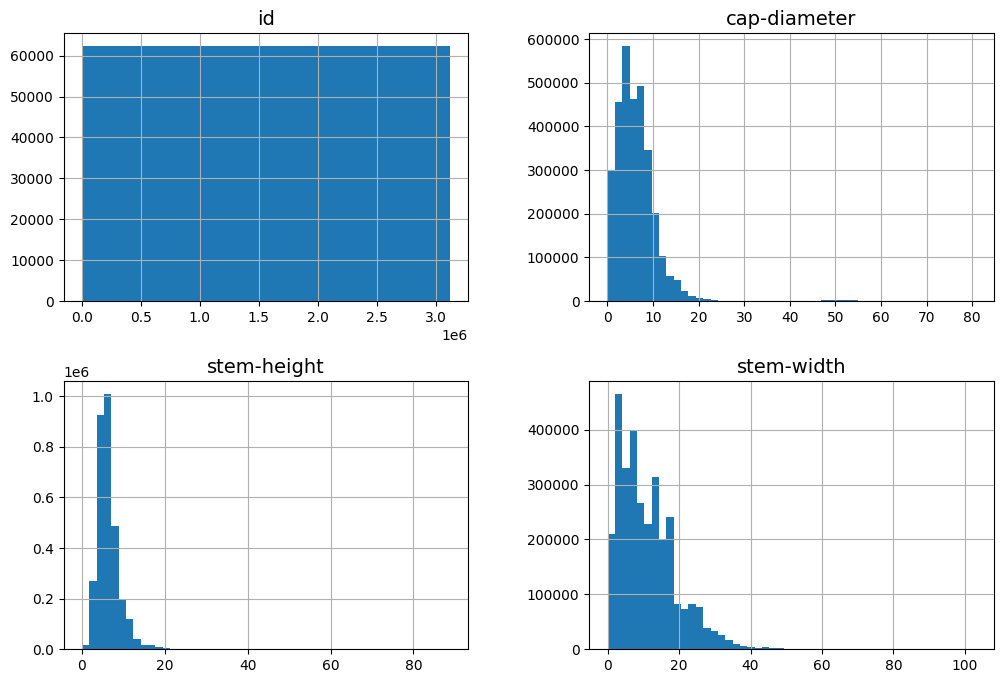

In [10]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

train_data.hist(bins=50, figsize=(12, 8))
plt.show()

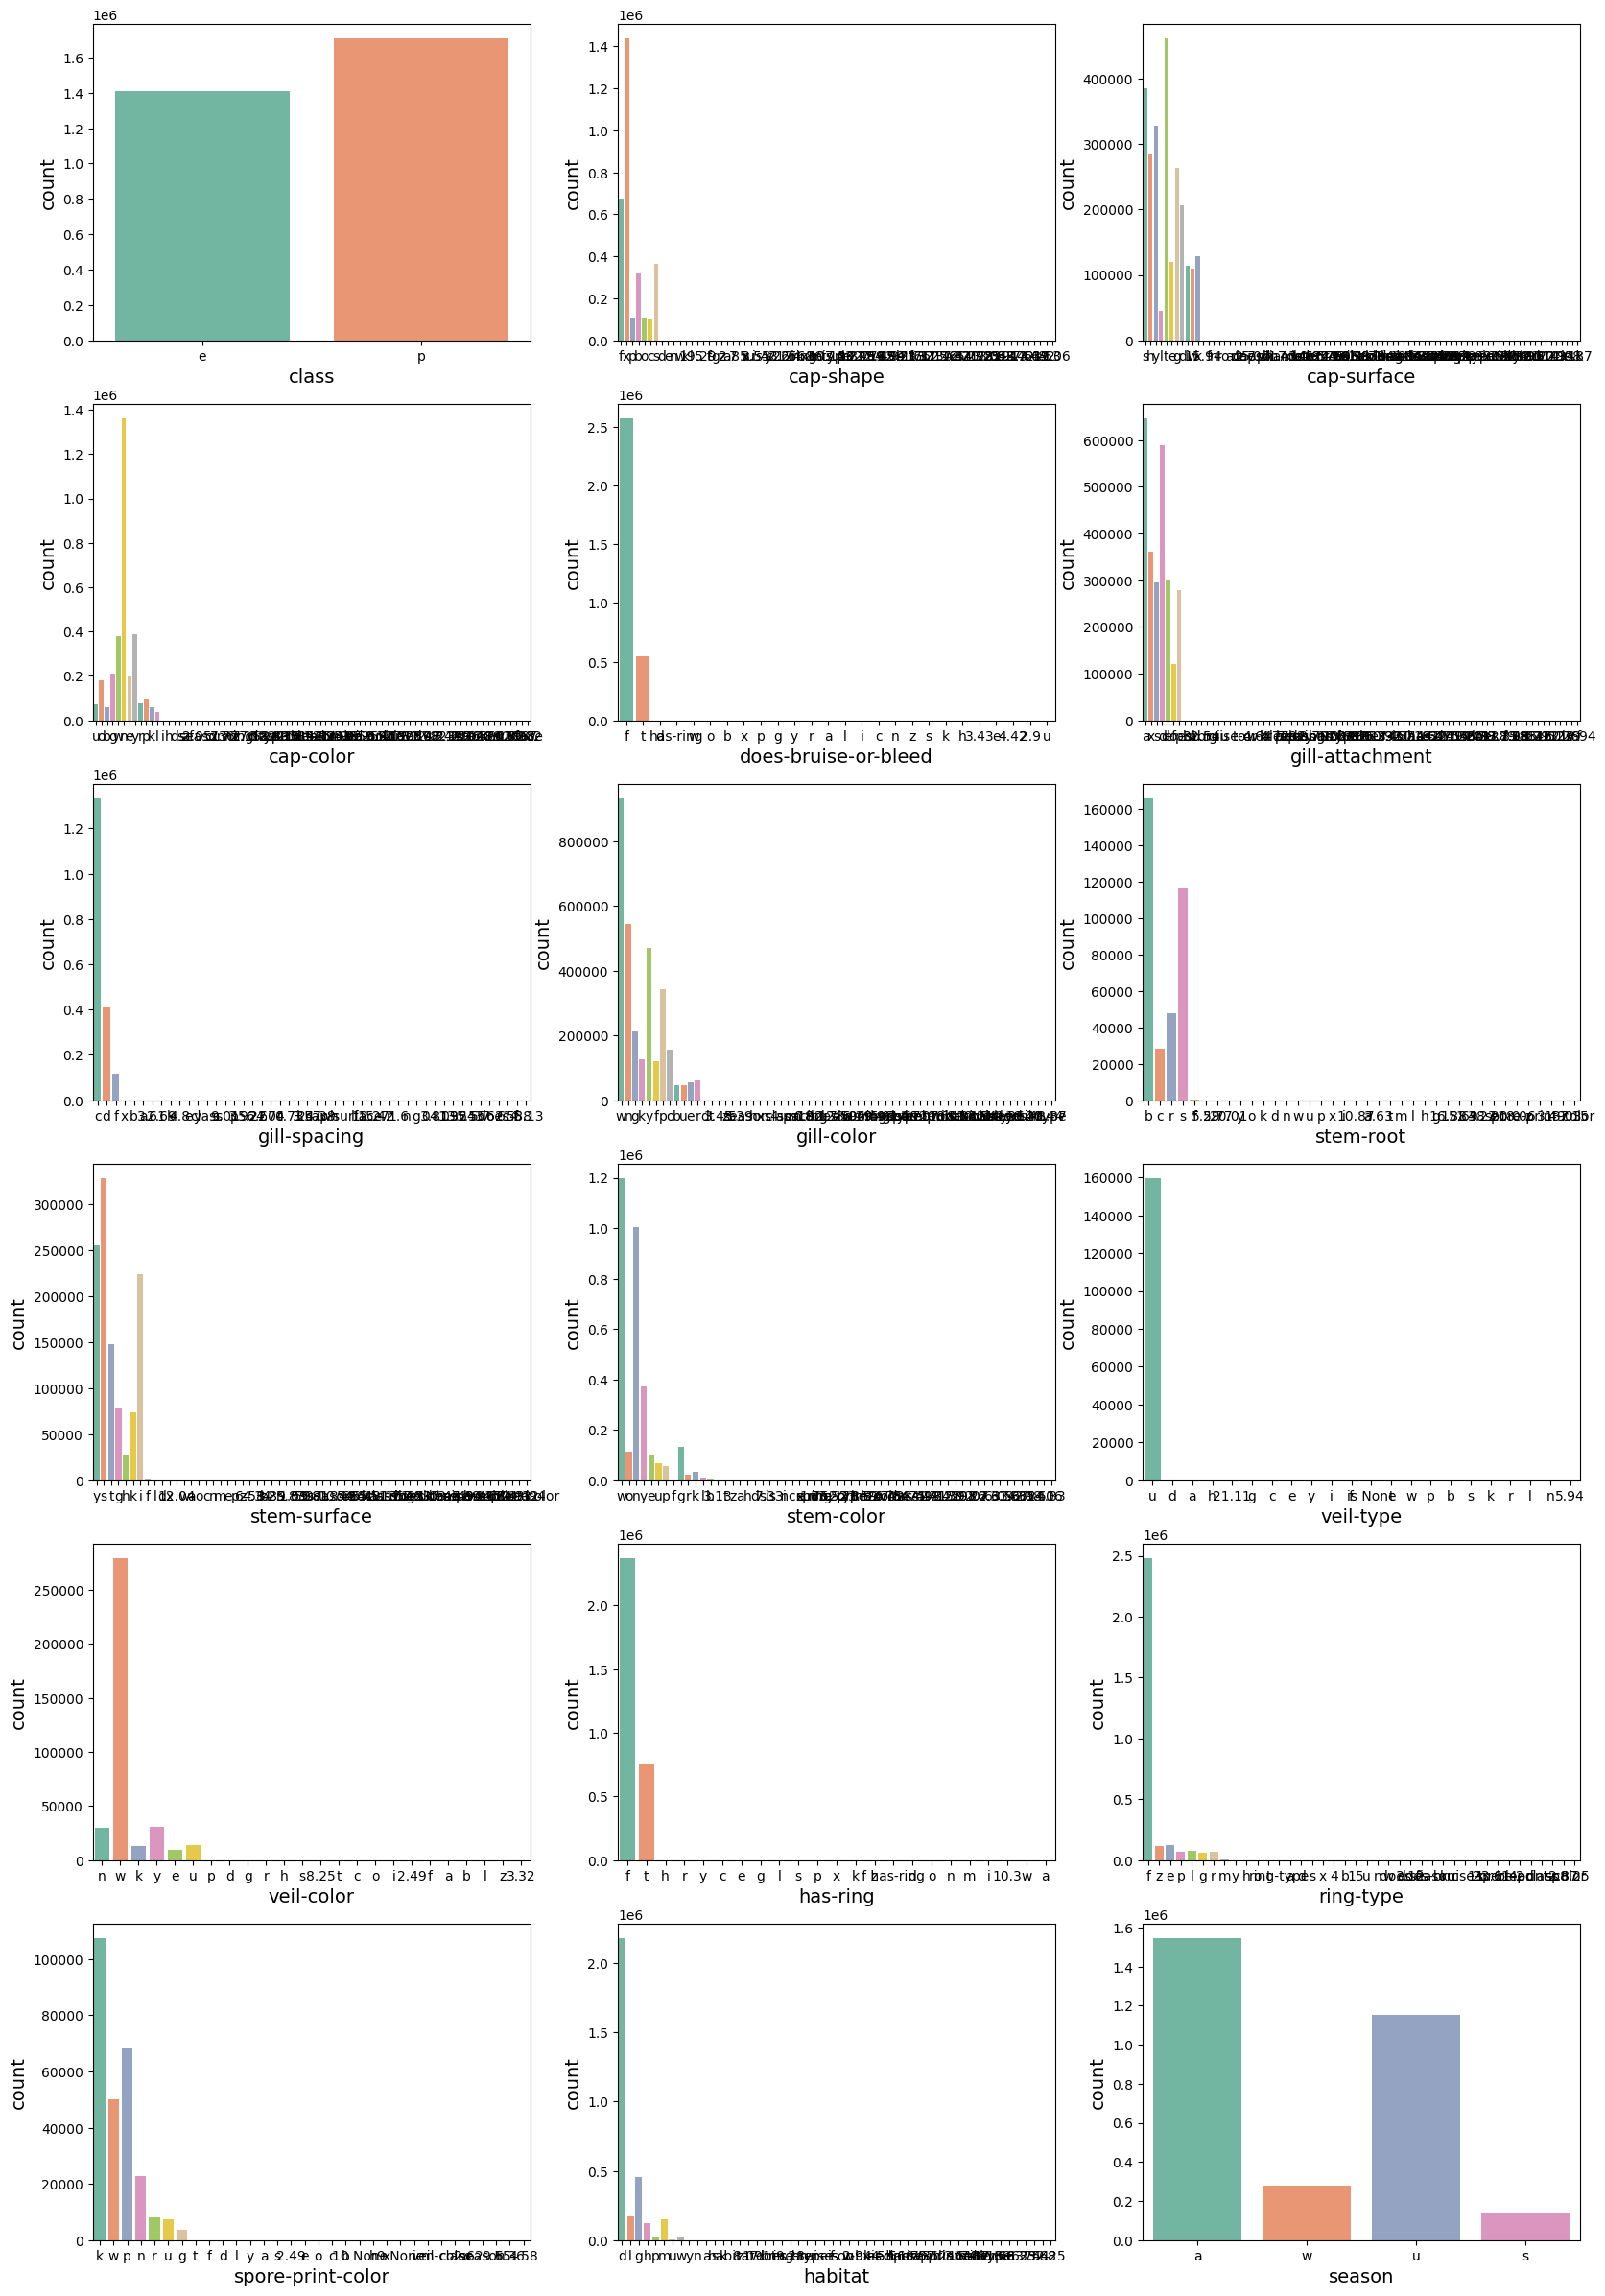

In [11]:
plt_row = 6
plt_col = 3

fig, axs = plt.subplots(plt_row, plt_col, figsize=(20, 30))

for idx in range(len(categorical_col)):
    row = idx // plt_col
    col = idx % plt_col  
    if "id" == categorical_col[idx]:
        continue
    else:
        sns.countplot(x=categorical_col[idx], data=train_data, palette="Set2", ax=axs[row, col])
                 

# EDA

In [12]:
merge_data = pd.concat([train_data, test_data])
print(merge_data.shape)
merge_data.tail()

(5194909, 22)


,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
2077959,5194904,NaN,0.88,x,g,w,f,a,d,w,...,NaN,NaN,e,NaN,NaN,f,f,NaN,d,u
2077960,5194905,NaN,3.12,x,s,w,f,d,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a
2077961,5194906,NaN,5.73,x,e,e,f,a,NaN,w,...,NaN,NaN,y,NaN,w,t,z,NaN,d,a
2077962,5194907,NaN,5.03,b,g,n,f,a,d,g,...,NaN,s,g,NaN,NaN,f,f,NaN,d,a
2077963,5194908,NaN,15.51,f,NaN,w,f,d,c,y,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,w


In [13]:
# id 삭제
merge_data.drop(labels="id", axis=1, inplace=True)
merge_data.head()

,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,e,8.80,f,s,u,f,a,c,w,4.51,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,p,4.51,x,h,o,f,a,c,n,4.79,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,e,6.94,f,s,b,f,x,c,w,6.85,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,e,3.88,f,y,g,f,s,NaN,g,4.16,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,e,5.85,x,l,w,f,d,NaN,w,3.37,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


In [14]:
# NaN 값이 너무 많은 column 삭제
nan_std = round(merge_data.shape[0] * 0.85)
for col in merge_data.columns:
    if merge_data[col].isnull().sum() > nan_std:
        merge_data.drop(labels=col, axis=1, inplace=True)
        categorical_col = categorical_col.drop(col)
        print(f"{col} is Delete")

stem-root is Delete
veil-type is Delete
veil-color is Delete
spore-print-color is Delete


In [15]:
# 삭제 후 다시 범주형 데이터 정리
# categorical_col = merge_data.select_dtypes(include=['object']).columns
categorical_col = categorical_col.drop("class")


In [16]:
# 범주형 데이터 encoding
encoder = LabelEncoder()

for col in categorical_col:
    merge_data[col] = encoder.fit_transform(merge_data[col])
merge_data.head()



,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-surface,stem-color,has-ring,ring-type,habitat,season
0,e,8.80,85,103,103,9,78,42,82,4.51,15.39,87,84,7,24,37,0
1,p,4.51,105,86,95,9,78,42,69,4.79,6.48,85,72,20,46,37,3
2,e,6.94,85,103,77,9,114,42,82,6.85,9.93,77,71,7,24,49,3
3,e,3.88,85,112,86,9,108,66,58,4.16,6.53,87,84,7,24,37,2
4,e,5.85,105,96,105,9,82,66,82,3.37,8.36,87,84,7,24,41,0


In [17]:
# NaN 값 채우기
# LabelEncoder()를 사용하면 NaN 값도 바뀜... ㅎㅎ
imputer = KNNImputer()
fill_knn = imputer.fit_transform(merge_data[["cap-diameter", "stem-height"]])
fill_knn = pd.DataFrame(fill_knn, columns=["cap-diameter", "stem-height"])
fill_knn.head(10)

,cap-diameter,stem-height
0,8.80,4.51
1,4.51,4.79
2,6.94,6.85
3,3.88,4.16
4,5.85,3.37
5,4.30,5.91
6,9.65,19.07
7,4.55,8.31
8,7.36,5.77
9,6.45,7.13


In [18]:
merge_data[["cap-diameter", "stem-height"]] = fill_knn

In [19]:
for col in merge_data.columns:
    print(f"{col}: {merge_data[col].isnull().sum()}")

class: 2077964
cap-diameter: 0
cap-shape: 0
cap-surface: 0
cap-color: 0
does-bruise-or-bleed: 0
gill-attachment: 0
gill-spacing: 0
gill-color: 0
stem-height: 0
stem-width: 0
stem-surface: 0
stem-color: 0
has-ring: 0
ring-type: 0
habitat: 0
season: 0


In [20]:
merge_data["class"] = encoder.fit_transform(merge_data["class"])

In [21]:
train_data = merge_data[:train_data.shape[0]] 
test_data = merge_data[train_data.shape[0]:] 

In [22]:
print(train_data.shape)
print(test_data.shape)

(3116945, 17)
(2077964, 17)


In [23]:
train_data.isnull().sum()

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

In [24]:
test_data.isnull().sum()

class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-surface            0
stem-color              0
has-ring                0
ring-type               0
habitat                 0
season                  0
dtype: int64

# 훈련

In [25]:
train_X, test_X, train_y, test_y = train_test_split(train_data.drop(['class'],axis=1), train_data["class"], test_size = 0.2, random_state =42, stratify=train_data["class"])

In [26]:
def mcc_metric(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    y_pred = (y_pred > 0.5).astype(int) 
    mcc = matthews_corrcoef(y_true, y_pred)
    return 'mcc', mcc

In [27]:
%%time
xgb_optuna_params = {
 #'tree_method': 'gpu_hist',
 'n_estimators': 100,
 'alpha': 2.956752183261538e-04,
 'subsample': 0.83,
 'colsample_bytree': 0.4,
 'max_depth': 15, 
 'min_child_weight': 6,
 'learning_rate': 0.013301,
 'gamma': 5.6e-08,
     #'device': "cuda"
}
model = XGBClassifier(                    
    **xgb_optuna_params
)
XGB = model.fit(
    train_X, 
    train_y, 
    eval_set=[(test_X, test_y)],
    eval_metric=mcc_metric)

[0]	validation_0-logloss:0.67762	validation_0-mcc:0.00000
[1]	validation_0-logloss:0.66811	validation_0-mcc:0.00000
[2]	validation_0-logloss:0.65730	validation_0-mcc:0.00000
[3]	validation_0-logloss:0.64778	validation_0-mcc:0.00000
[4]	validation_0-logloss:0.64168	validation_0-mcc:0.00000
[5]	validation_0-logloss:0.63467	validation_0-mcc:0.00000
[6]	validation_0-logloss:0.62613	validation_0-mcc:0.30205
[7]	validation_0-logloss:0.61721	validation_0-mcc:0.47863
[8]	validation_0-logloss:0.60850	validation_0-mcc:0.60236
[9]	validation_0-logloss:0.60027	validation_0-mcc:0.72177
[10]	validation_0-logloss:0.59372	validation_0-mcc:0.79075
[11]	validation_0-logloss:0.58744	validation_0-mcc:0.83016
[12]	validation_0-logloss:0.57785	validation_0-mcc:0.89088
[13]	validation_0-logloss:0.57050	validation_0-mcc:0.91206
[14]	validation_0-logloss:0.56366	validation_0-mcc:0.92970
[15]	validation_0-logloss:0.55540	validation_0-mcc:0.94620
[16]	validation_0-logloss:0.54743	validation_0-mcc:0.95452
[17]	va

In [28]:
y_pred = XGB.predict(test_X)

In [29]:
score = matthews_corrcoef(test_y, y_pred)
print('MCC:', score)

MCC: 0.9834391512177943


In [30]:
tmp = test_data.drop(['class'],axis=1)
test_pred_prob = XGB.predict(tmp)

In [31]:
test_pred_class = encoder.inverse_transform(test_pred_prob)
submission['class']= test_pred_class

In [32]:
submission.to_csv('submission.csv', index = False)
pd.read_csv('submission.csv')

,id,class
0,3116945,e
1,3116946,p
2,3116947,p
3,3116948,p
4,3116949,e
...,...,...
2077959,5194904,p
2077960,5194905,p
2077961,5194906,p
2077962,5194907,e
